In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
def panda_from_gspreadsheet(key, sheet_name='Sheet1', header=0):
    url = 'https://docs.google.com/spreadsheets/d/{key}/gviz/tq?tqx=out:csv&sheet={sheet_name}&headers=1'.format(
      key=key, sheet_name=sheet_name.replace(' ', '%20'))
    return pd.read_csv(url, header=header)

def risultati(key):
    dr = panda_from_gspreadsheet(key, sheet_name='DB')
    return dr

key = '1SUHVbmaA8sUDcHGr0fjH7p_3QNj7F5tWXBtukodj3aw'
d5 =  panda_from_gspreadsheet(key, sheet_name='5D')
d42 =  panda_from_gspreadsheet(key, sheet_name='42D')
dr = risultati(key)
df = pd.concat([d5, d42],ignore_index=True)

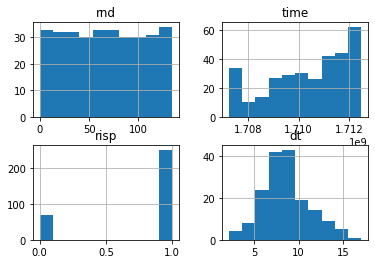

rate successo totale: 78.61635220125787 % su: 318
prove fatte corrette 250 prove fatte 318 totale prove: 135


In [10]:
# statistiche di successo/fallimento
dr=risultati(key)
dr.hist()
plt.show()
print("rate successo totale:", 100*len(dr[dr.risp==1])/len(dr),"% su:", len(dr))
tn = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d 00:00:00')
t = time.mktime(time.strptime(tn, '%Y-%m-%d 00:00:00'))
if len(dr[(dr.time>=t)])>0:
    print("rate successo giornaliero:", 100*len(dr[(dr.risp==1) & (dr.time>=t)])/len(dr[(dr.time>=t)]),"%, su:", len(dr[(dr.time>=t)]))
print("prove fatte corrette", len(dr[dr.risp==1]), "prove fatte", len(dr), "totale prove:", len(df))

  arrivalDate   rnd          time  risp          dt  bad    success
0  2024-02-11  1986   58053697353    20    0.000000   14  58.823529
1  2024-02-18   843   20498623442     8    0.000000    4  66.666667
2  2024-02-25  1934   46137226253    15    0.000000   12  55.555556
3  2024-03-03  1620   42731143534    20    0.000000    5  80.000000
4  2024-03-10  2459   58135265305    30    0.000000    4  88.235294
5  2024-03-17  2058   47893416405    21  100.279044    7  75.000000
6  2024-03-24  2817   78713555769    40  379.932261    6  86.956522
7  2024-03-31  3325   82160794769    38  395.001778   10  79.166667
8  2024-04-07  4181  109583587878    58  571.841652    6  90.625000


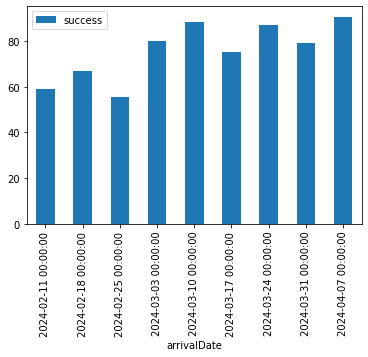

In [15]:
# statistiche settimanli
def swap(risp):
    return int(not(risp))
dr['bad']= dr.risp.apply(swap)
dr['arrivalDate'] = pd.to_datetime(dr.time, unit='s')
df1 = dr.resample('W', on='arrivalDate').sum().dropna().reset_index()
df1['success']=(df1['risp']/(df1['risp']+df1['bad'])*100)
print (df1)
df1.plot.bar(x='arrivalDate', y='success')

plt.show()

In [20]:
#
# questo pezzo di codice puoi servire per mettere nelle colonne "try" di 5D e 42D 
# le prove corrette "1" e quelle fallite "0" nell'ordine temporale
#
import pandas as pd
import gspread
from google.oauth2 import service_account
import json
credentials = service_account.Credentials.from_service_account_file(
    '.google_credentials.json')
scope = ['https://spreadsheets.google.com/feeds']
creds_scope = credentials.with_scopes(scope)
client = gspread.authorize(creds_scope)

sheet1 = client.open_by_key(key).worksheet("5D")
sheet2 = client.open_by_key(key).worksheet("42D")
sheet3 = client.open_by_key(key).worksheet("DB")
# piu' light caricare il file senza autenticazione (come sopra)
# d5=pd.DataFrame.from_dict(sheet1.get_all_records())
# d45=pd.DataFrame.from_dict(sheet2.get_all_records())
# df = pd.concat([d5, d45],ignore_index=True)
# dr=pd.DataFrame.from_dict(sheet3.get_all_records())
dr=risultati(key)
dr['arrivalDate'] = pd.to_datetime(dr.time, unit='s')

drs=dr.sort_values(['rnd', 'arrivalDate'])
rnds = -1
step = 0 
provefatte = len(dr)-1
for i, rnd in enumerate(drs.rnd):
    if rnd == rnds:
        step = step+1
    else:
        step = 0
    rnds = rnd
    col = 7+step
    ntry = len(drs[drs.rnd.values == rnd])
    nfail = len(drs[(drs.risp.values == 0) & (drs.rnd.values == rnd)])
    if rnd<len(d5):
        row = rnd+2
        # print(i,rnd, "--", row, col, drs.risp.values[i], "--", ntry, nfail, ntry-nfail)
        sheet1.update_cell(row, col, str(drs.risp.values[i]))
    else:
        row = rnd-len(d5)+2
        # print(i,rnd, "--", row, col, drs.risp[i], "--", ntry, nfail, ntry-nfail)
        sheet2.update_cell(row, col, str(drs.risp.values[i]))
    print('updating db {:d}/{:d}'.format(i, provefatte), end="\r")
    time.sleep(1) # necessario per i limiti di google sulle big query
print('update done')

update done 317/318
